# Matriz Moran Sul

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/matriz_moran_sul.ipynb`

## Bibliotecas

In [ ]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 30kB/s 
     |████████████████████████████████| 14.7MB 301kB/s 
     |████████████████████████████████| 225kB 2.7MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=4d0869c36275f25ec79ca0bfe90ec908981feba97dcd46a2828dc7587b0c3c58
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
     |████████████████████████████████| 2.4MB 6.1MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 266kB 32.5MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 235kB 30.1MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379082 sha256=f2ccb1eb14707abf5dc9b1922b8997f19c64

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [2]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [3]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [4]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [5]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [6]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [7]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [8]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [9]:
dados.reset_index(level = 0, inplace = True)

In [10]:
dados.shape

(2293, 9)

In [11]:
dados = dados.merge(cod, on='mun')

In [12]:
# dados = dados.loc[:, ['mun', 'nome_mun', 'nome_meso', 'apolices_contratadas', 'total_segurado_mil',
#       'soma_premio_total_mil', 'total_subvencao_mil',
#       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
#       'apolices_indenizadas']]

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

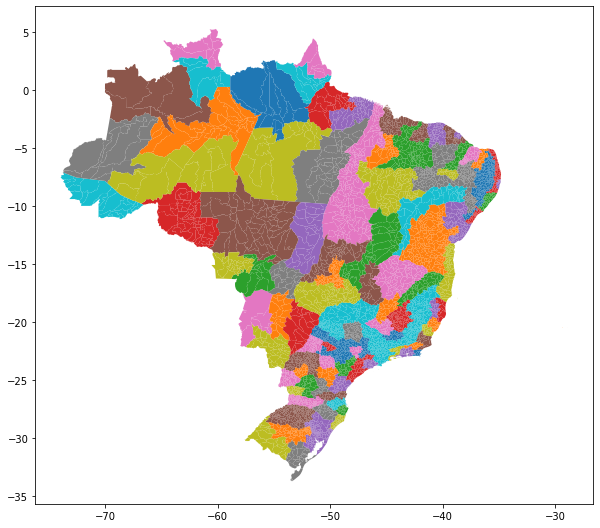

In [22]:
dados_br.plot(column='nome_meso', figsize=(10, 10), k=4); # , cmap='OrRd',  cmap='plasma'

## Sul

In [23]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

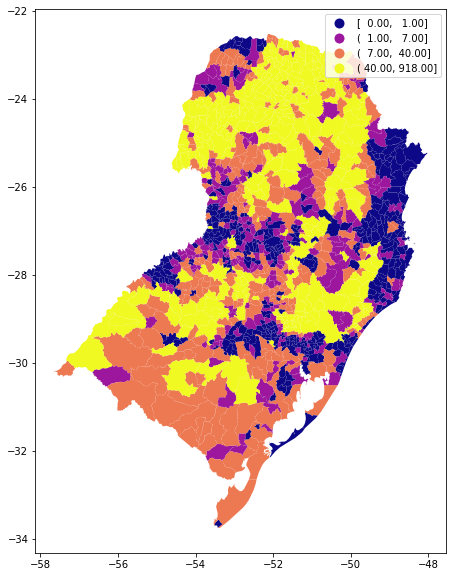

In [25]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True, k=4, cmap='plasma'); # , cmap='OrRd'

## Matriz de I de Moran - Sul

Teste de construção de uma matriz de I de Moran para cada variável


### Criando a matriz

In [26]:
dados_sul.columns

Index(['Unnamed: 0', 'uf', 'nome_uf', 'mun', 'nome_mun', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'codmun6', 'regiao', 'nome_regiao',
       'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [27]:
moran_matrix_sul = dados_sul

In [28]:
retirar = ['uf', 'rm', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'Unnamed: 0'] #  'geometry',
moran_matrix_sul = moran_matrix_sul.drop(retirar, axis = 1)

### I de Moran local para variáveis

In [29]:
moran_matrix_sul.columns

Index(['nome_mun', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas'],
      dtype='object')

In [30]:
# demora um pouco
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [31]:
for variavel in moran_matrix_sul.drop(['nome_mun', 'geometry'], axis = 1).columns:
    moran_matrix_sul[variavel] = Moran_Local(dados_sul[variavel].values, w).Is

In [32]:
moran_matrix_sul = moran_matrix_sul.set_index('nome_mun')

In [33]:
moran_matrix_sul.describe()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.554577,0.407989,0.311057,0.313660,0.511224,0.667412,0.753585,0.526146
std,2.496036,1.611436,1.748716,1.687035,5.031638,1.657368,1.651204,4.066280
min,-0.851689,-1.900218,-1.627056,-1.564152,-0.684362,-2.222645,-1.047989,-0.448808
25%,0.036658,0.022756,0.020069,0.022403,0.037007,0.095321,0.050585,0.044636
50%,0.155966,0.154430,0.099496,0.100658,0.067566,0.230349,0.324175,0.084187
75%,0.215086,0.214419,0.132846,0.132438,0.075366,0.288801,0.483881,0.095562
max,42.812370,26.931481,32.121703,32.217335,114.793126,20.940502,15.492572,93.833055


### Mapa I de Moran - Sul

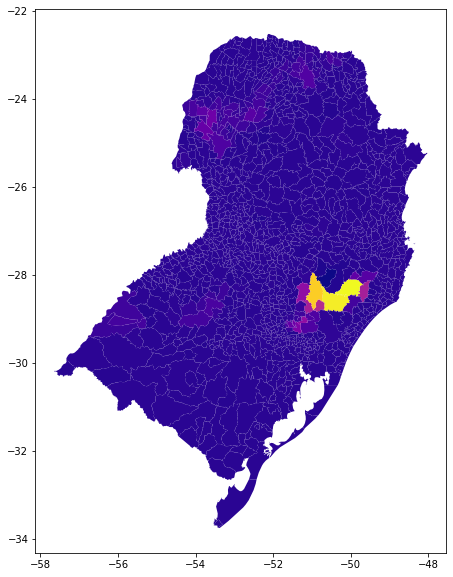

In [34]:
moran_matrix_sul.plot(column='soma_premio_total_mil', figsize=(10, 10),  k=4, cmap = 'plasma'); # , cmap='OrRd'

## Análise de agrupamento - I de Moran - Sul

In [35]:
# subselecionar variáveis
X = moran_matrix_sul.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [36]:
Z = linkage(X, method='ward')

In [37]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

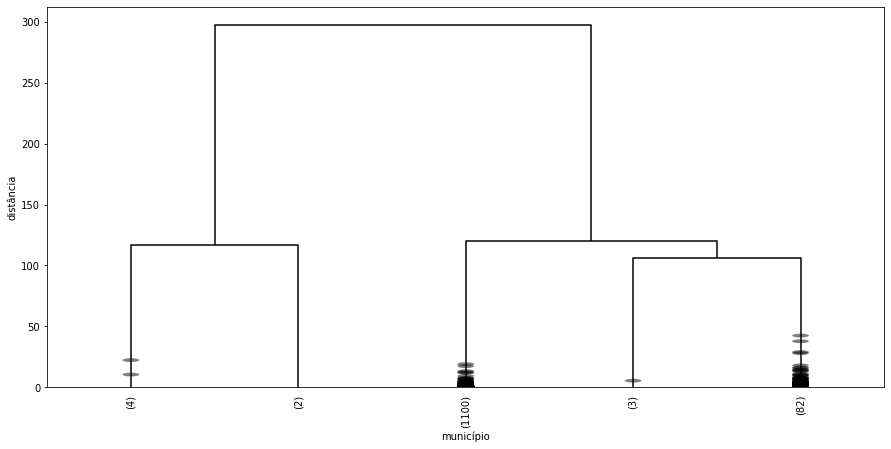

In [38]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [39]:
Z = linkage(X, method='ward')

In [40]:
# definir a distância de corte baseando no dendrograma
max_d = 60
grupos = cut_tree(Z, height=max_d)

### Métricas

In [62]:
dados_metrics_sul = moran_matrix_sul.drop('geometry', axis=1)

In [63]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

1917.37 0.54 0.85


In [43]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
moran_matrix_sul['grupo'] = grupos
# moran_matrix.head(2)

In [44]:
# contagem de observações em cada grupo
moran_matrix_sul.grupo.value_counts()

0    1100
1      80
4       4
2       3
5       2
3       2
Name: grupo, dtype: int64

In [45]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,0.159538,0.148179,0.096458,0.097020,0.068240,0.299268,0.406873,0.084023
1,3.404805,2.381320,1.729842,1.793333,1.598320,5.168026,5.391646,2.338658
2,3.042600,20.720090,30.647500,28.805955,1.160162,0.557636,1.304030,0.247381
3,27.988375,10.358507,3.506272,3.811465,9.733078,0.175687,0.199976,19.116446
4,22.453485,7.575456,4.062293,4.414197,43.487663,4.232359,2.009248,39.922641
5,28.852705,9.616870,5.386671,5.841433,104.520297,16.648470,3.139443,74.228352


In [46]:
# mediana das variáveis para cada grupo
moran_matrix_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
grupo,,,,,,,,
0,0.141031,0.137402,0.088398,0.092029,0.065291,0.209548,0.274301,0.080003
1,2.887336,1.643358,1.114363,1.175112,0.918988,5.149146,4.504399,1.488537
2,3.020046,22.996490,31.157322,27.819979,0.832220,0.807456,1.182836,0.177101
3,27.988375,10.358507,3.506272,3.811465,9.733078,0.175687,0.199976,19.116446
4,22.887372,7.785660,4.103572,4.457754,42.496690,3.284480,1.752689,37.856551
5,28.852705,9.616870,5.386671,5.841433,104.520297,16.648470,3.139443,74.228352


### As observações de cada grupo

In [47]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupo com I de Moran

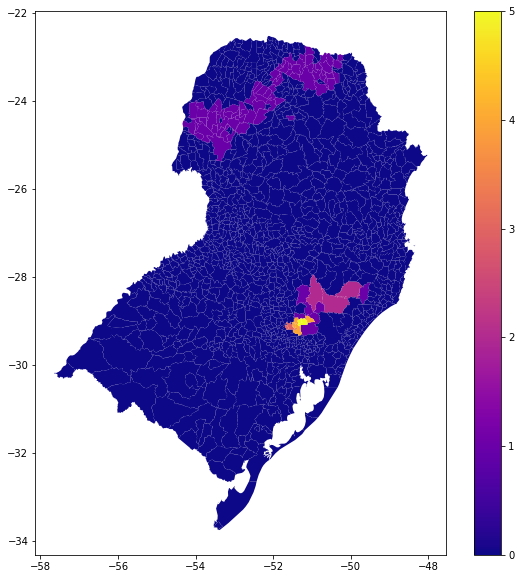

In [50]:
moran_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap = 'plasma'); # , cmap='OrRd'

## K-Médias I de Moran - Sul

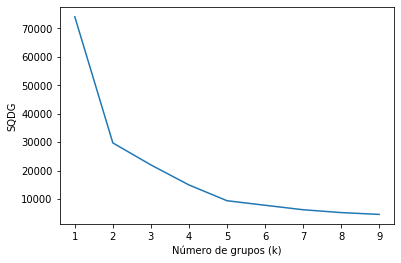

In [51]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(moran_matrix_sul.drop('geometry', axis=1))
    moran_matrix_sul['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [52]:
k = 5

In [53]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

### Métricas

In [64]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

2022.7 0.57 0.86


In [65]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
moran_matrix_sul['grupo'] = kmeans.labels_

In [66]:
# contagens
moran_matrix_sul.grupo.value_counts()

0    1097
2      84
3       5
4       3
1       2
Name: grupo, dtype: int64

In [67]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [68]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
moran_matrix_sul.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,0.153226,0.142651,0.093212,0.093734,0.066076,0.298429,0.387031,0.082740,0.045579
1,28.852705,9.616870,5.386671,5.841433,104.520297,16.648470,3.139443,74.228352,3.500000
2,3.623903,2.452423,1.723589,1.787319,1.603962,4.943831,5.407734,2.427107,4.619048
3,24.234086,8.405900,4.143607,4.501628,37.825721,3.451926,1.701221,36.559578,3.000000
4,3.042600,20.720090,30.647500,28.805955,1.160162,0.557636,1.304030,0.247381,4.000000


In [69]:
# mediana das variáveis para cada grupo
moran_matrix_sul.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,grupos
grupo,,,,,,,,,
0,0.139611,0.136964,0.088202,0.091602,0.065302,0.209470,0.271907,0.080003,0.0
1,28.852705,9.616870,5.386671,5.841433,104.520297,16.648470,3.139443,74.228352,3.5
2,2.834980,1.643358,1.114363,1.175112,0.934810,5.011156,4.699181,1.488537,5.0
3,24.723952,10.400309,4.468860,4.851354,42.483645,1.994236,1.450998,37.372495,2.0
4,3.020046,22.996490,31.157322,27.819979,0.832220,0.807456,1.182836,0.177101,4.0


In [70]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com I de Moran - Sul

In [71]:
moran_matrix_sul['grupo'] = moran_matrix_sul['grupo'].astype('category')

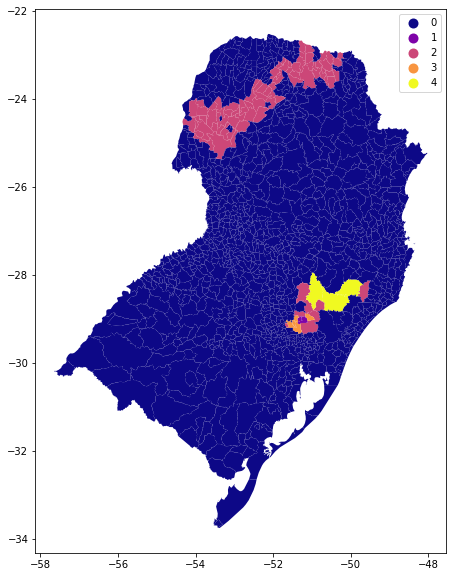

In [72]:
moran_matrix_sul.plot(column='grupo', figsize=(10, 10), legend=True, k=4, cmap = 'plasma'); # , cmap='OrRd'